In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def safe_exp(x, cap=100):
    return np.exp(np.clip(x, None, cap))

## Import datasets

In [ ]:
phecodes = pd.read_excel('./Phecode/phecode_counts_v2.xlsx')
phecodes = phecodes.loc[phecodes['include'] == 'Y']['phecode']

sdu = pd.read_csv('./Datasets/sider_input.csv')
sdu = sdu.loc[sdu['phecode'].isin(phecodes)]
sdu['g-p'] = sdu['gene'] + sdu['phecode']
sdu = sdu.sort_values('phase',ascending=False).drop_duplicates('g-p')

otu = pd.read_csv('./Datasets/ot_input.csv')
otu = otu.loc[otu['phecode'].isin(phecodes)]
otu['g-p'] = otu['gene'] + otu['phecode']
otu = otu.sort_values('phase',ascending=False).drop_duplicates('g-p')

agp = pd.read_csv('./Datasets/all_gp.csv')
agp = agp.loc[agp['phecode'].isin(phecodes)]
agp['g-p'] = agp['gene'] + agp['phecode']
agp = agp.drop_duplicates('g-p')

input = otu.sample(frac=1,random_state=0).reset_index(drop=True)
output = sdu.copy()

In [5]:
print(f"Unique gene-phenotype pairs: Open Targets = {otu['g-p'].nunique()}, SIDER = {sdu['g-p'].nunique()}")
print(f"Indicated gene-phenotype pairs: Open Targets = {otu['indication'].sum()}, SIDER = {sdu['indication'].sum()}")

non_indicated_open_targets = len(otu.loc[otu['indication'] == 0])
non_indicated_sider = len(sdu.loc[sdu['indication'] == 0])

activators_open_targets = otu['activator'].sum()
activators_sider = sdu['activator'].sum()

inhibitors_open_targets = otu['inhibitor'].sum()
inhibitors_sider = sdu['inhibitor'].sum()

print("\nOpen Targets Data:")
print(f"  Non-indicated pairs: {non_indicated_open_targets}")
print(f"  Non-indicated + Activators: {non_indicated_open_targets + activators_open_targets} (Activators: {activators_open_targets})")
print(f"  Non-indicated + Inhibitors: {non_indicated_open_targets + inhibitors_open_targets} (Inhibitors: {inhibitors_open_targets})")

print("\nSIDER Data:")
print(f"  Non-indicated pairs: {non_indicated_sider}")
print(f"  Non-indicated + Activators: {non_indicated_sider + activators_sider} (Activators: {activators_sider})")
print(f"  Non-indicated + Inhibitors: {non_indicated_sider + inhibitors_sider} (Inhibitors: {inhibitors_sider})")

Unique gene-phenotype pairs: Open Targets = 121212, SIDER = 65017
Indicated gene-phenotype pairs: Open Targets = 4907.0, SIDER = 2433.0

Open Targets Data:
  Non-indicated pairs: 116305
  Non-indicated + Activators: 117348.0 (Activators: 1043.0)
  Non-indicated + Inhibitors: 119857.0 (Inhibitors: 3552.0)

SIDER Data:
  Non-indicated pairs: 62584
  Non-indicated + Activators: 63069.0 (Activators: 485.0)
  Non-indicated + Inhibitors: 64135.0 (Inhibitors: 1551.0)


## Univariable associations

In [ ]:
# SIDER
curr_var = []
results = []

all_vars = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b', 'c_g', 'c_e', 'c_b', 'b_g', 'b_e', 'b_b',\
            'c_only_g','c_only_e', 'c_only_b', 'b_only_g','b_only_e', 'b_only_b']
temp = sdu.drop_duplicates()

for i in all_vars:
    
    exclude = [n for n in all_vars if n != i]
    X = temp[[i,'oe','BI','CM','CV','EM','GI','GU','MS','NS','RE']].rename({i:'test_var'},axis=1) # did not include DE due to failure to converge
    X = sm.add_constant(X)
    y = temp['indication']
    model = sm.Logit(y, X).fit(disp=0, method='bfgs', maxiter=1000)

    # Using safe exponential function for coefficients and confidence intervals
    params = safe_exp(model.params)
    conf = model.conf_int()
    conf = safe_exp(conf)

    # Extracting and formatting p-values
    p_values = model.pvalues.apply(lambda x: f"{x:.2E}")

    # Formatting results with mean, 95% confidence interval, and p-value
    formatted_results = params.apply(lambda x: f"{x:.2f}") + \
                        " (" + conf[0].apply(lambda x: f"{x:.2f}") + \
                        "-" + conf[1].apply(lambda x: f"{x:.2f}") + ")"
    results.append(formatted_results)
    curr_var.append(i)
    
sd_results = pd.DataFrame(results).set_axis(curr_var)
sd_results.to_excel('./Results/sider_or.xlsx', index=False)

# Open Targets
curr_var = []
results = []

all_vars = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b', 'c_g', 'c_e', 'c_b', 'b_g', 'b_e', 'b_b',\
            'c_only_g','c_only_e', 'c_only_b', 'b_only_g','b_only_e', 'b_only_b']
temp = otu.drop_duplicates()

for i in all_vars:
    
    exclude = [n for n in all_vars if n != i]
    X = temp[[i,'oe','BI','CM','CV','EM','GI','GU','MS','NS','RE','SO']].rename({i:'test_var'},axis=1) # did not include DE due to failure to converge
    X = sm.add_constant(X)
    y = temp['indication']
    model = sm.Logit(y, X).fit(disp=0, method='bfgs', maxiter=1000)

    # Using safe exponential function for coefficients and confidence intervals
    params = safe_exp(model.params)
    conf = model.conf_int()
    conf = safe_exp(conf)

    # Extracting and formatting p-values
    p_values = model.pvalues.apply(lambda x: f"{x:.2E}")

    # Formatting results with mean, 95% confidence interval, and p-value
    formatted_results = params.apply(lambda x: f"{x:.2f}") + \
                        " (" + conf[0].apply(lambda x: f"{x:.2f}") + \
                        "-" + conf[1].apply(lambda x: f"{x:.2f}") + ")"
    results.append(formatted_results)
    curr_var.append(i)

ot_results = pd.DataFrame(results).set_axis(curr_var)
ot_results.to_excel('./Results/opentargets_or.xlsx', index=False)

# Combine
b = pd.read_excel('./Results/opentargets_or.xlsx')[['test_var']].set_axis(['Open Targets'],axis=1)
c = pd.read_excel('./Results/sider_or.xlsx')['test_var'].to_list()
b['SIDER'] = c
b['Variable'] = ['EVA','HGMD','OMIM','L2G',\
                 'Phecode','Phecode','Phecode',\
                 'Continuous','Continuous','Continuous',\
                 'Binary','Binary','Binary',\
                 'Continuous - Phecode','Continuous - Phecode','Continuous - Phecode',\
                 'Binary - Phecode','Binary - Phecode','Binary - Phecode']
b['Analysis'] = ['','','','',\
                 'Common variant','Rare variant','Ultra-rare variant',\
                 'Common variant','Rare variant','Ultra-rare variant',\
                 'Common variant','Rare variant','Ultra-rare variant',\
                 'Common variant','Rare variant','Ultra-rare variant',\
                 'Common variant','Rare variant','Ultra-rare variant']
b['Name'] = ['EVA','HGMD','OMIM','L2G','Common P','Rare P','Ultra-rare P',\
                 'Common C','Rare C','Ultra-rare C','Common B','Rare B','Ultra-rare B',\
                 'Common C-P','Rare C-P','Ultra-rare C-P','Common B-P','Rare B-P','Ultra-rare B-P']
b[['Variable','Analysis','Name','Open Targets','SIDER']].to_excel('./Results/odds_ratios.xlsx', index=False)


In [ ]:
ors = pd.read_excel('./Results/odds_ratios.xlsx')

a = ors[['Name','Open Targets']].rename({'Open Targets':'OR CI'},axis=1)
b = ors[['Name','SIDER']].rename({'SIDER':'OR CI'},axis=1)

a['Name'] = pd.Categorical(a['Name'], ['EVA','HGMD','OMIM','L2G','Common P','Common B','Common C',               
                                       'Rare P','Rare B','Rare C',
                                       'Ultra-rare P','Ultra-rare B','Ultra-rare C',
                                     'Common B-P','Common C-P',
                                       'Rare B-P','Rare C-P',
                                       'Ultra-rare B-P','Ultra-rare C-P'])
a = a.sort_values('Name')

a['Type'] = ['Existing evidence','Existing evidence','Existing evidence','Existing evidence',\
             'Common variants','Common variants','Common variants',\
            'Rare variants','Rare variants','Rare variants',\
             'Ultra-rare variants','Ultra-rare variants','Ultra-rare variants',\
            'Common variants','Common variants','Rare variants','Rare variants','Ultra-rare variants','Ultra-rare variants']

def parse_odds_ratio(s):
    parts = s.split(' ')
    odds_ratio = float(parts[0])
    ci_lower, ci_upper = map(float, parts[1].strip('()').split('-'))
    return odds_ratio, ci_lower, ci_upper


plot_df1 = a.loc[~a['Name'].str.contains('C-P|B-P')]
plot_df2 = a.loc[a['Name'].str.contains('C-P|B-P')]

def prepare_df(plot_df):
    plot_df[['OR', 'CI Lower', 'CI Upper']] = plot_df['OR CI'].apply(
        lambda x: pd.Series(parse_odds_ratio(x))
    )
    features = plot_df['Name'].unique()
    feature_mapping = {feature: i for i, feature in enumerate(features)}
    dodge_amount = 0.2
    return plot_df

plot_df1 = prepare_df(plot_df1)
plot_df2 = prepare_df(plot_df2)

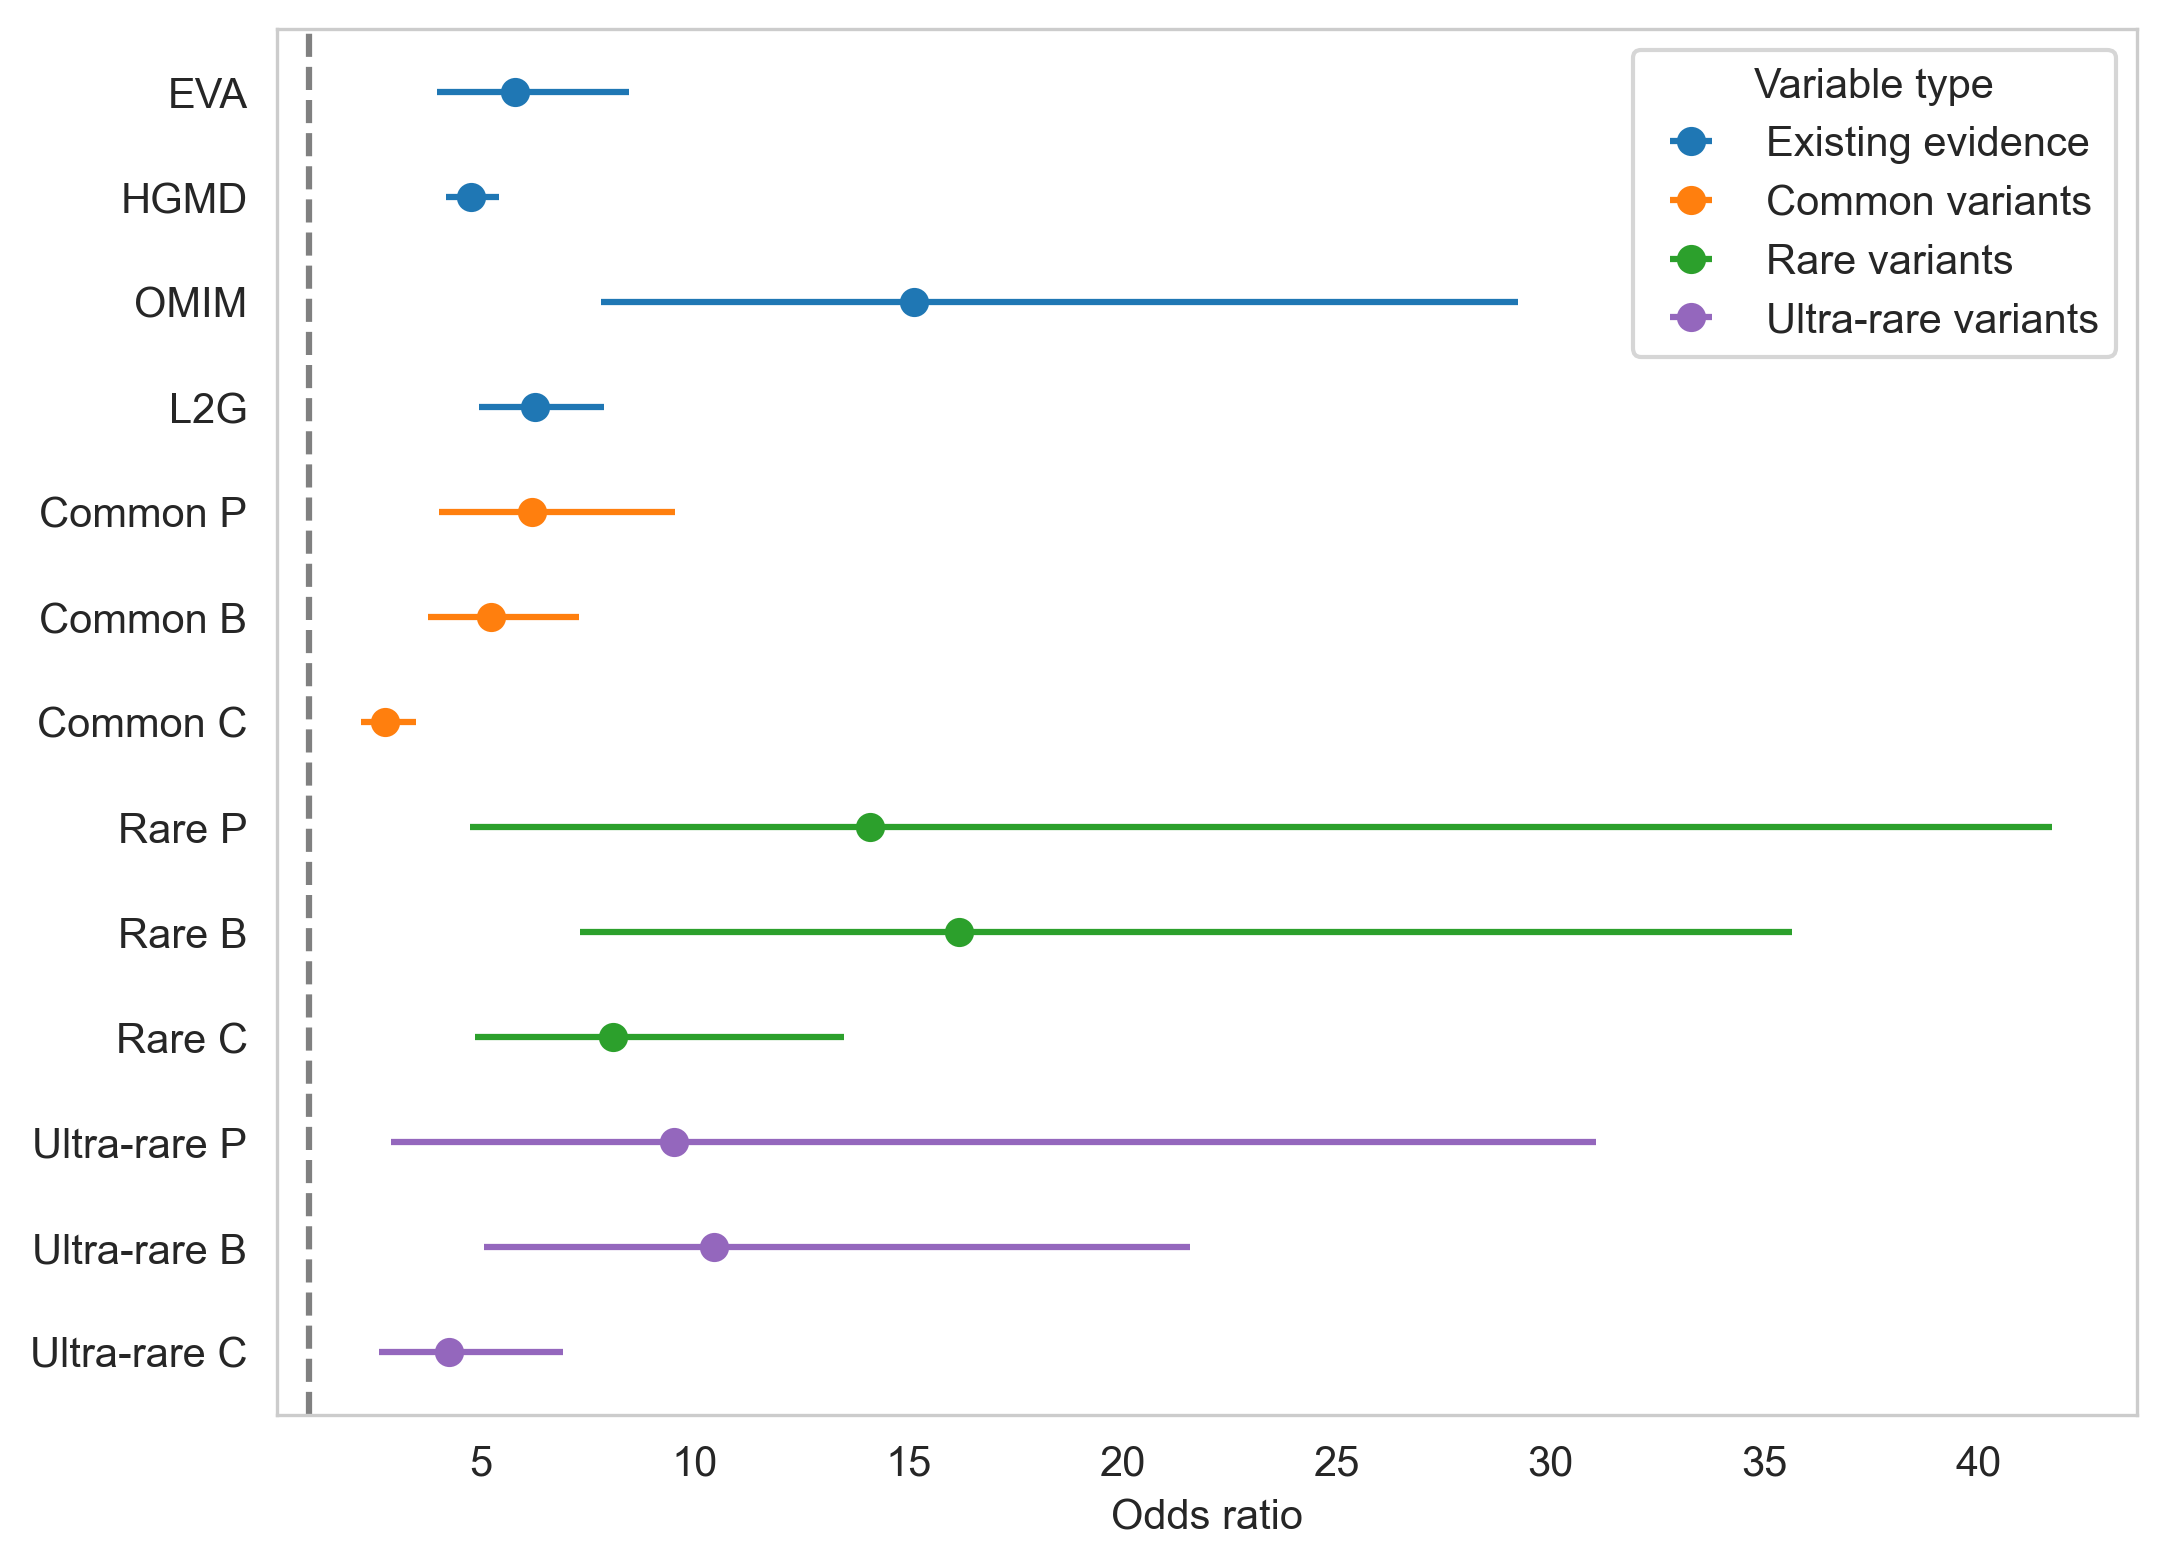

In [ ]:
sns.set_style(style='whitegrid')

fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

plot_df1['y_position'] = np.arange(len(plot_df1))

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_order = ['Existing evidence', 'Common variants', 'Rare variants', 'Ultra-rare variants']
skip_red_color = [color for color in color_cycle if color != '#d62728']
color_map = {type_name: skip_red_color[i % len(skip_red_color)] for i, type_name in enumerate(custom_order)}

for type_name, group in plot_df1.groupby('Type'):
    ax.errorbar(group['OR'], group['y_position'], 
                xerr=[group['OR'] - group['CI Lower'], group['CI Upper'] - group['OR']], 
                fmt='o', color=color_map[type_name], label=type_name)

handles, labels = ax.get_legend_handles_labels()
unique_labels = sorted(set(labels), key=lambda x: custom_order.index(x))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, title="Variable type")

ax.set_yticks(plot_df1['y_position'])
ax.set_yticklabels(plot_df1['Name'])
ax.invert_yaxis()

ax.set_xlabel('Odds ratio')
ax.set_ylabel('')

ax.grid(False)
ax.axvline(x=1, color='grey', linestyle='--')
plt.show()

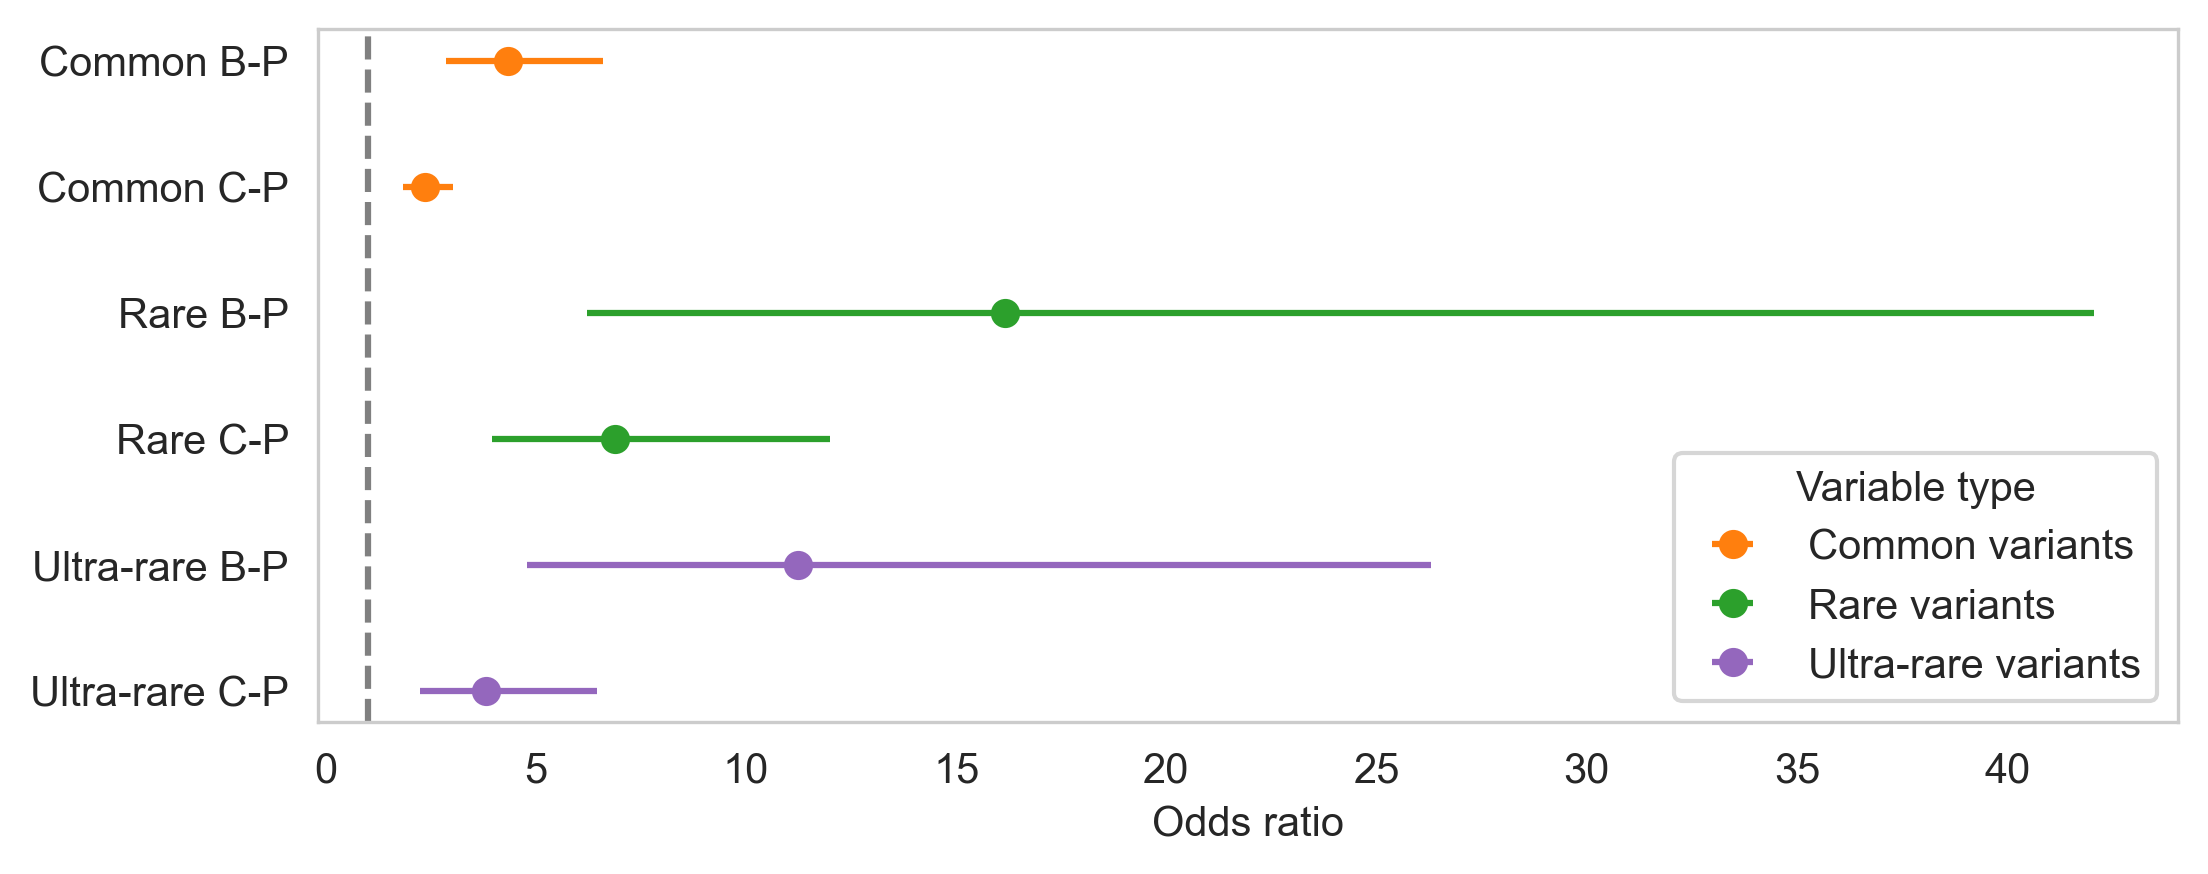

In [ ]:
sns.set_style(style='whitegrid')

fig, ax = plt.subplots(figsize=(8, 6*(6/12)), dpi=300)

plot_df2['y_position'] = np.arange(len(plot_df2))

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_order = ['Existing evidence', 'Common variants', 'Rare variants', 'Ultra-rare variants']
skip_red_color = [color for color in color_cycle if color != '#d62728']
color_map = {type_name: skip_red_color[i % len(skip_red_color)] for i, type_name in enumerate(custom_order)}


for type_name, group in plot_df2.groupby('Type'):
    ax.errorbar(group['OR'], group['y_position'], 
                xerr=[group['OR'] - group['CI Lower'], group['CI Upper'] - group['OR']], 
                fmt='o', color=color_map[type_name], label=type_name)

handles, labels = ax.get_legend_handles_labels()
unique_labels = sorted(set(labels), key=lambda x: custom_order.index(x))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, title="Variable type", loc="lower right")

ax.set_yticks(plot_df2['y_position'])
ax.set_yticklabels(plot_df2['Name'])
ax.invert_yaxis()

ax.set_xlabel('Odds ratio')
ax.set_ylabel('')

ax.grid(False)
ax.axvline(x=1, color='grey', linestyle='--')
plt.show()

In [ ]:
agp = agp.merge(otu[['gene','phecode','indication']].sort_values(['indication'],ascending=False).drop_duplicates(['gene','phecode']).rename({'indication':'ot'},axis=1),how='left')
agp = agp.merge(sdu[['gene','phecode','indication']].sort_values(['indication'],ascending=False).drop_duplicates(['gene','phecode']).rename({'indication':'sider'},axis=1),how='left').fillna(0)
agp_pos = agp.loc[(agp['ot'] == 1) | (agp['sider'] == 1)]

cols = ['p_g', 'p_e', 'p_b', 'b_g', 'b_e', 'b_b', 'c_g', 'c_e', 'c_b', ]
results = {}
for col in cols:
    result = agp_pos[agp_pos[col] == 1].groupby('phecode')['ot'].sum()
    results[col] = result

rdf = pd.DataFrame(results).fillna(0)
rdf.reset_index(inplace=True)
rdf.rename(columns={'index': 'phecode'}, inplace=True)
rdf = rdf.merge(otu.loc[otu['indication'] == 1][['phecode']].drop_duplicates(), how='outer').fillna(0)
rdf = rdf.merge(sdu.loc[sdu['indication'] == 1][['phecode']].drop_duplicates(), how='outer').fillna(0)

plot = pd.melt(rdf, id_vars='phecode')
plot.loc[plot['variable'].str.contains('_g'), 'type'] = 'Common variant'
plot.loc[plot['variable'].str.contains('_e'), 'type'] = 'Rare variant'
plot.loc[plot['variable'].str.contains('_b'), 'type'] = 'Ultra-rare variant'
plot.loc[plot['variable'].str.contains('p_'), 'Phenotype'] = 'P'
plot.loc[plot['variable'].str.contains('c_'), 'Phenotype'] = 'C'
plot.loc[plot['variable'].str.contains('b_'), 'Phenotype'] = 'B'


## Gene counts

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

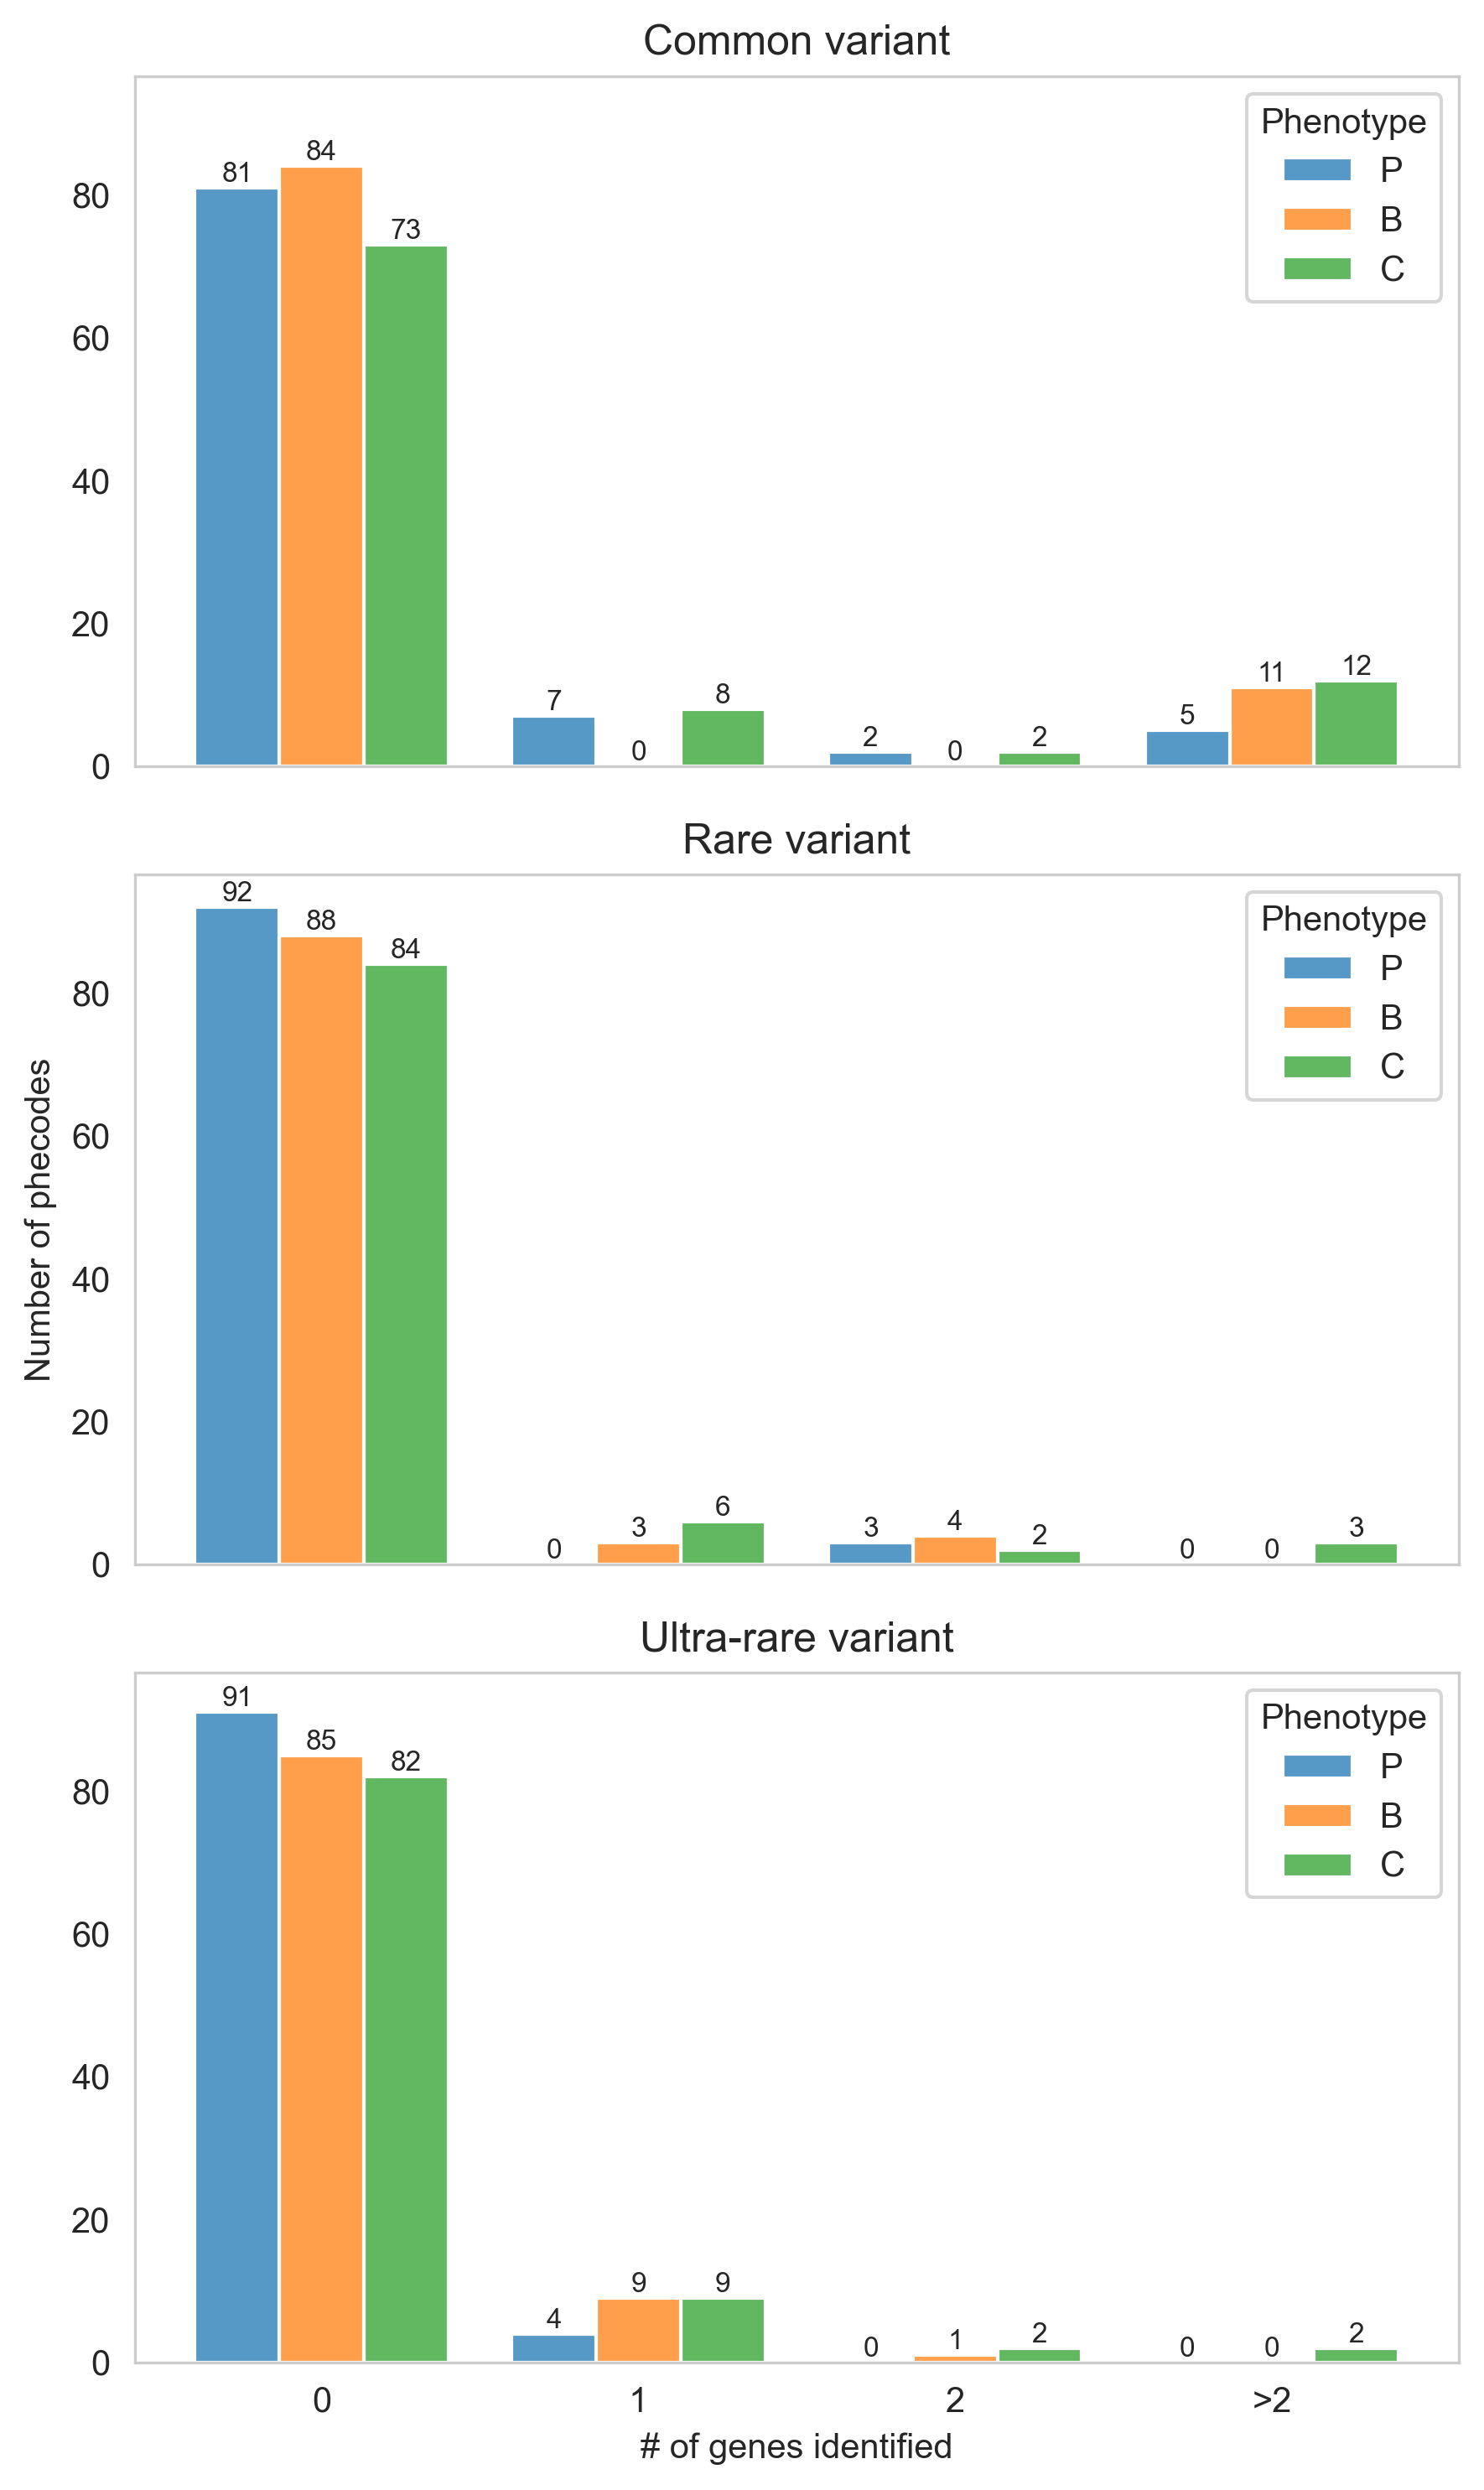

In [11]:
sns.set_style(style='whitegrid')

plot['binned_value'] = pd.Categorical(
    np.where(plot['value'] > 2, '>2', plot['value'].astype(int).astype(str)),
    categories=['0', '1', '2', '>2'],
    ordered=True
)

types_to_plot = ['Common variant', 'Rare variant', 'Ultra-rare variant']

fig, axes = plt.subplots(len(types_to_plot), 1, figsize=(6, 10), dpi=300, sharex=True, sharey=True)

for ax, type_value in zip(axes, types_to_plot):
    ax.grid(False)

    sns.histplot(
        data=plot[plot['type'] == type_value],
        x='binned_value',
        hue='Phenotype',
        multiple='dodge',
        discrete=True,
        shrink=0.8,
        ax=ax
    )
    ax.set_title(f"{type_value}")
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.bar_label(ax.containers[0], fontsize=8);
    ax.bar_label(ax.containers[1], fontsize=8);
    ax.bar_label(ax.containers[2], fontsize=8);
    
    if type_value == 'Rare variant':
        ax.set_ylabel('Number of phecodes')
    if type_value == 'Ultra-rare variant':
        ax.set_xlabel('# of genes identified')

plt.tight_layout()
plt.show()

## Evidence counts

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43636/528321374.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = plt.cm.get_cmap('Blues', 256) # Get the original Blues colormap


Text(287.38888888888886, 0.5, '')

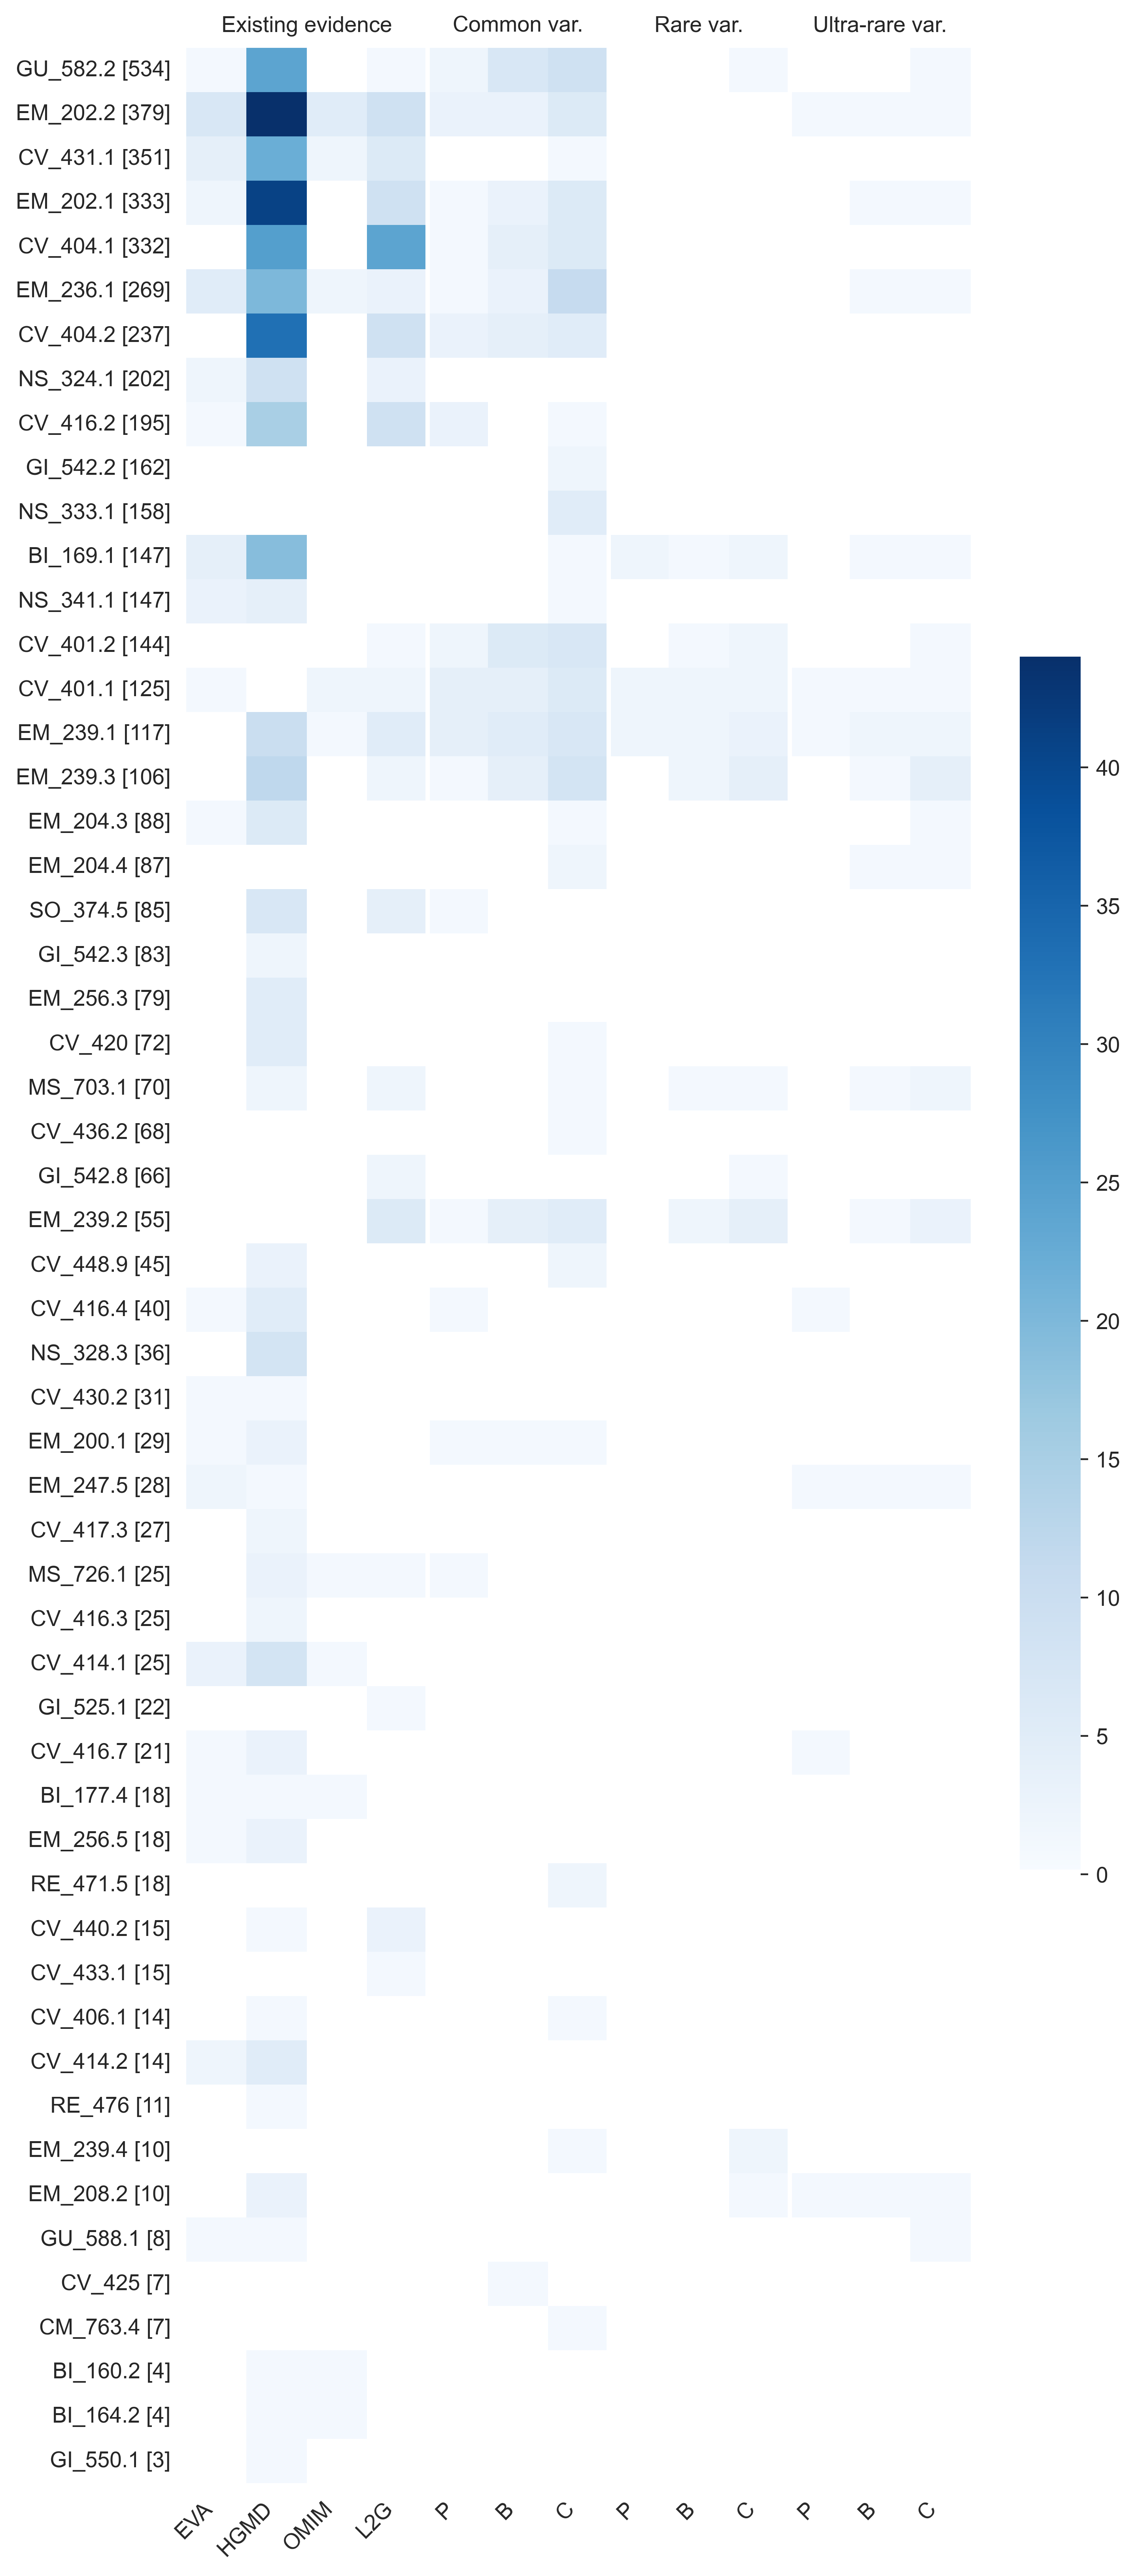

In [18]:
from matplotlib.colors import ListedColormap

sns.set_style(style='whitegrid')

os_comb = pd.concat([otu.loc[otu['indication'] == 1], sdu.loc[sdu['indication'] == 1]])\
        .sort_values('phase',ascending=False).drop_duplicates(['gene','phecode'])

temp = os_comb.groupby('phecode')[['indication','EVA','HGMD','OMIM','l2g','p_g','b_g','c_g','p_e','b_e','c_e','p_b','b_b','c_b']].sum()
temp = temp.reset_index().sort_values('indication', ascending=False)
temp['indication'] = temp['indication'].astype(int)
temp['id'] = temp['phecode'] + ' [' + temp['indication'].astype(str) + ']'
temp = temp.set_index('id').drop(['phecode','indication'],axis=1)
#temp = temp.div(temp['indication'], axis=0).drop('indication',axis=1)

ta = temp.copy()

temp = temp.set_axis(['EVA','HGMD','OMIM','L2G','P','B','C','P','B','C','P','B','C'],axis=1)
temp = temp.loc[temp.sum(axis=1) > 0]

blues = plt.cm.get_cmap('Blues', 256) # Get the original Blues colormap
newcolors = blues(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1]) # RGBA color for white
newcolors[:1, :] = white # Set the first color entry to white
newcmp = ListedColormap(newcolors)

plt.figure(figsize=(8, 20), dpi=400)
g = sns.heatmap(temp, cmap=newcmp, cbar_kws={'shrink': 0.5})
g = plt.axvline(4, color='white', lw=2)
g = plt.axvline(7, color='white', lw=2)
g = plt.axvline(10, color='white', lw=2)
g = plt.xticks(rotation=45, ha='right')

y_pos = -0.5  # This places the text just above the graph
plt.text(2, y_pos, "Existing evidence", ha='center', va='center')
plt.text(5.5, y_pos, "Common var.", ha='center', va='center')
plt.text(8.5, y_pos, "Rare var.", ha='center', va='center')
plt.text(11.5, y_pos, "Ultra-rare var.", ha='center', va='center')

plt.ylabel('')